<a href="https://colab.research.google.com/github/mdrk300902/demo-repo/blob/main/PneumoniaXpert_Improved_Chest_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PneumoniaXpert: AI-Driven Chest X-Ray Analysis for Early Pneumonia Detection

## Project Overview

PneumoniaXpert is a deep learning-based project designed to automatically detect pneumonia from chest X-ray images. Early and accurate diagnosis of pneumonia can significantly improve patient outcomes and reduce mortality rates, especially in resource-limited settings.

## Problem Statement

Chest X-rays are commonly used to diagnose pneumonia, but manual interpretation is time-consuming and prone to errors, especially where radiologists are scarce. The goal of this project is to build a reliable AI model capable of distinguishing between normal and pneumonia-affected chest X-rays, assisting clinicians in timely and accurate diagnosis.

## Workflow

1. **Data Acquisition:**  
   Download and prepare a public pneumonia chest X-ray dataset with labeled normal and pneumonia cases.

2. **Data Preprocessing and Augmentation:**  
   Apply image resizing, normalization, and augmentations such as random flips, rotations, and brightness adjustments to improve model generalization.

3. **Model Development:**  
   Use a pretrained convolutional neural network (DenseNet121) adapted for two-class classification.

4. **Handling Class Imbalance:**  
   Employ weighted sampling and weighted loss functions to balance the uneven distribution of normal and pneumonia images.

5. **Training and Validation:**  
   Train the model with augmented data, monitor performance transparently through loss and accuracy metrics, and validate on a separate dataset split.

6. **Evaluation:**  
   Assess the model using classification reports and confusion matrices on the unseen test data to measure precision, recall, F1-score, and overall accuracy.

7. **Deployment Readiness:**  
   Save the trained model weights for future usage in clinical decision support systems or further processing.



In [35]:
# PneumoniaXpert: Improved Chest X-Ray Classification
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Use KaggleHub download path
dataset_path = path  # Assume 'path' from kagglehub.dataset_download

# Auto-locate train/val/test folders
def find_xray_dirs(base):
    subs = os.listdir(base)
    if set(["train", "val", "test"]).issubset(set(subs)):
        return os.path.join(base, "train"), os.path.join(base, "val"), os.path.join(base, "test")
    for sub in subs:
        possible = os.path.join(base, sub)
        if os.path.isdir(possible):
            if set(["train", "val", "test"]).issubset(set(os.listdir(possible))):
                return os.path.join(possible, "train"), os.path.join(possible, "val"), os.path.join(possible, "test")
    raise RuntimeError("Couldn't find train/val/test folders.")

train_dir, val_dir, test_dir = find_xray_dirs(dataset_path)
print("Train folder:", train_dir)
print("Val folder:", val_dir)
print("Test folder:", test_dir)

Train folder: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Val folder: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test folder: /kaggle/input/chest-xray-pneumonia/chest_xray/test


### 1. Augmentation for robustness

In [36]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=basic_transform)
test_data = datasets.ImageFolder(test_dir, transform=basic_transform)
classes = train_data.classes
print("Classes:", classes)

Classes: ['NORMAL', 'PNEUMONIA']


### 2. WeightedRandomSampler to balance classes

In [37]:
targets = [s[1] for s in train_data.samples]
class_counts = np.bincount(targets)
weights = class_counts.max() / class_counts
sample_weights = np.array([weights[t] for t in targets])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

### 3. Visualize some augmented train images

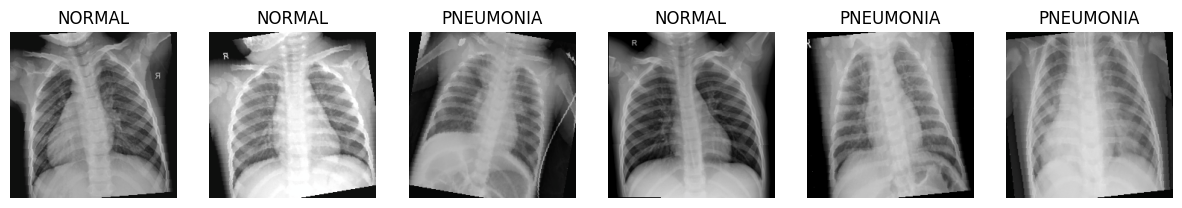

In [38]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(15,4))
for i in range(6):
    img = images[i].permute(1,2,0).numpy()
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')
plt.show()

### 4. Model: DenseNet121 + Dropout

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet = models.densenet121(pretrained=True)
densenet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(densenet.classifier.in_features, len(classes))
)
model = densenet.to(device)


### 5. Weighted loss & optimizer (try lower lr for stability)

In [40]:
class_weights = torch.tensor(class_counts.max() / class_counts, dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

### 6. Training loop (10 epochs for smoothing)

In [41]:
n_epochs = 10
train_losses, val_losses, val_accs = [], [], []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    v_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            v_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    val_losses.append(v_loss / len(val_loader))
    val_accs.append(correct / total)
    print(f"Epoch {epoch+1}/{n_epochs}: Train loss={train_losses[-1]:.4f}, Val loss={val_losses[-1]:.4f}, Val acc={val_accs[-1]:.2%}")

Epoch 1/10: Train loss=0.1578, Val loss=0.1359, Val acc=100.00%
Epoch 2/10: Train loss=0.0601, Val loss=0.0615, Val acc=100.00%
Epoch 3/10: Train loss=0.0452, Val loss=0.0751, Val acc=100.00%
Epoch 4/10: Train loss=0.0320, Val loss=0.3310, Val acc=81.25%
Epoch 5/10: Train loss=0.0330, Val loss=0.1062, Val acc=100.00%
Epoch 6/10: Train loss=0.0241, Val loss=0.1354, Val acc=100.00%
Epoch 7/10: Train loss=0.0239, Val loss=0.0153, Val acc=100.00%
Epoch 8/10: Train loss=0.0165, Val loss=0.0527, Val acc=100.00%
Epoch 9/10: Train loss=0.0144, Val loss=0.0365, Val acc=100.00%
Epoch 10/10: Train loss=0.0119, Val loss=0.0971, Val acc=100.00%


### 7. Training progress plot

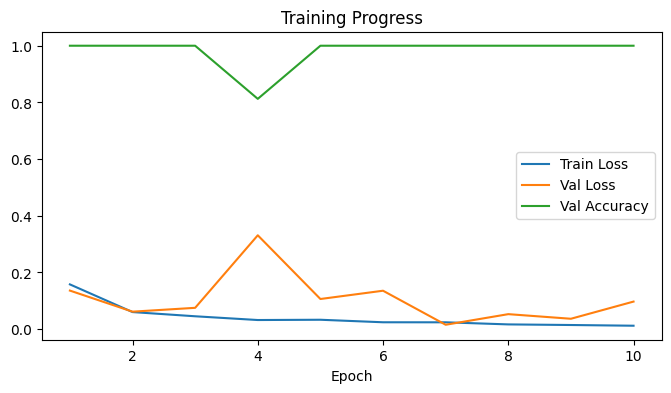

In [42]:
plt.figure(figsize=(8,4))
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), val_losses, label='Val Loss')
plt.plot(range(1, n_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Progress")
plt.show()

### 8. Test set evaluation & confusion matrix

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.59      0.74       234
   PNEUMONIA       0.80      1.00      0.89       390

    accuracy                           0.84       624
   macro avg       0.90      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



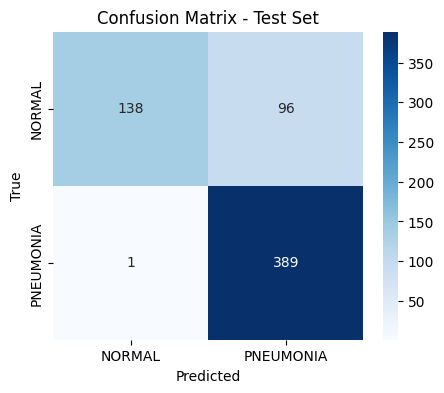

In [43]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(lbls.numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Test Set')
plt.show()

### 9. Save model weights

In [44]:
torch.save(model.state_dict(), "pneumoniaxpert_best_weights.pth")